Code to analyze the Beta diversity

In [1]:
# importing all required packages & notebook extensions at the start of the notebook
import pandas as pd
from qiime2 import Visualization
from seaborn import scatterplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from qiime2 import Artifact
import skbio
from scipy import stats
from scipy.spatial.distance import squareform
from itertools import combinations

%matplotlib inline

In [2]:
#all variables
Data_raw='Data/raw'
Data_classified='Data/classified'
Data_diversity='Data/diversity'

<div style="background-color: skyblue; padding: 10px;">
    Titles
    </div>
<div style="background-color: aliceblue; padding: 10px;">
    Results

## Creating the necessary files  
<div style="background-color: skyblue; padding: 10px;">


### Creating the files on all metadata

Adjusting merged_output.tsv to adapt for analysis without problems (no spaces in column titles)

In [ ]:
df = pd.read_csv(f'{Data_raw}/merged_output.tsv', sep='\t')
# Keep first column name, modify the rest
new_columns = [df.columns[0]] + [col.replace(' ', '_').replace('/', '_') for col in df.columns[1:]]
df.columns = new_columns
df.to_csv(f'{Data_raw}/merged_output_usable.tsv', sep='\t', index=False)

Calculate diversity metrics

In [5]:
! qiime diversity core-metrics \
  --i-table $Data_classified/table-filtered.qza \
  --m-metadata-file $Data_raw/merged_output.tsv\
  --p-sampling-depth 3000 \
  --output-dir $Data_diversity/core-metrics-results-merged

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/diversity/core-metrics-results-merged/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results-merged/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results-merged/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results-merged/evenness_vector.qza
Saved DistanceMatrix to: Data/diversity/core-metrics-results-merged/jaccard_distance_matrix.qza
Saved DistanceMatrix to: Data/diversity/core-metrics-results-merged/bray_curtis_distance_matrix.qza
Saved PCoAResults to: Data/diversity/core-metrics-results-merged/jaccard

The following code was then submitted as a job on Euler, due to too little memory capacity on Jupyterhub

#!/bin/bash
#SBATCH --job-name=kmerizer
#SBATCH --time=04:00:00
#SBATCH --mem-per-cpu=32GB
#SBATCH --cpus-per-task=4
#SBATCH --output=kmerizer.log
source /cluster/home/nschwager/miniconda3/etc/profile.d/conda.sh
source ~/.bashrc
conda activate qiime2-amplicon-2025.10
qiime kmerizer core-metrics \
  --i-table /cluster/home/nschwager/kmerizer/table-filtered.qza \
  --i-sequences /cluster/home/nschwager/kmerizer/rep-seqs-filtered.qza \
  --m-metadata-file /cluster/home/nschwager/kmerizer/merged_output.tsv \
  --p-sampling-depth 3000 \
  --output-dir /cluster/scratch/home/kmerizer/kmerizer-results-merged

### Creating files on just sourdough data

Filter metadata to only contain sourdough metadata

In [24]:
df = pd.read_csv(f'{Data_raw}/merged_output_usable.tsv', sep="\t")

columns_to_check = ["sample_type"]

df_filtered = df[df["sample_type"] == "sourdough"]

df_filtered.to_csv(f'{Data_diversity}/filtered-metadata/meta_sourdough.tsv', sep="\t", index=False)

First filtering the coresponding tables so that diversity metrics can be culculated on just the sourdough data

In [6]:
!qiime feature-table filter-samples \
  --i-table $Data_classified/table-filtered.qza \
  --m-metadata-file $Data_raw/merged_output.tsv  \
  --p-where "sample_type='sourdough'" \
  --o-filtered-table $Data_classified/table-filtered-sourdough_only.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/classified/table-filtered-sourdough_only.qza


In [7]:
!qiime feature-table filter-seqs \
  --i-data $Data_classified/rep-seqs-filtered.qza \
  --i-table $Data_classified/table-filtered-sourdough_only.qza \
  --o-filtered-data $Data_classified/rep-seqs-filtered-sourdough_only.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[Sequence] to: Data/classified/rep-seqs-filtered-sourdough_only.qza


Creating the metrics files

In [8]:
! qiime diversity core-metrics \
  --i-table $Data_classified/table-filtered-sourdough_only.qza \
  --m-metadata-file $Data_raw/merged_output.tsv\
  --p-sampling-depth 3000 \
  --output-dir $Data_diversity/core-metrics-results-merged-sourdough-only

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/diversity/core-metrics-results-merged-sourdough-only/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results-merged-sourdough-only/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results-merged-sourdough-only/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results-merged-sourdough-only/evenness_vector.qza
Saved DistanceMatrix to: Data/diversity/core-metrics-results-merged-sourdough-only/jaccard_distance_matrix.qza
Saved DistanceMatrix to: Data/diversity/core-metrics-results-merged-sourdough-only/bray_curtis_di

In [9]:
!qiime kmerizer core-metrics \
  --i-table $Data_classified/table-filtered-sourdough_only.qza \
  --i-sequences $Data_classified/rep-seqs-filtered-sourdough_only.qza \
  --m-metadata-file $Data_raw/merged_output.tsv\
  --p-sampling-depth 3000 \
  --output-dir $Data_diversity/kmerizer-results-merged-sourdough-only

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/diversity/kmerizer-results-merged-sourdough-only/rarefied_table.qza
Saved FeatureTable[Frequency] to: Data/diversity/kmerizer-results-merged-sourdough-only/kmer_table.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/kmerizer-results-merged-sourdough-only/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/kmerizer-results-merged-sourdough-only/shannon_vector.qza
Saved DistanceMatrix to: Data/diversity/kmerizer-results-merged-sourdough-only/jaccard_distance_matrix.qza
Saved DistanceMatrix to: Data/diversity/kmerizer-results-merged-sourdough-only/bray_curtis_distance_matrix.qza
Saved PCoAResu

### Creating files on just hand data

First filtering the coresponding tables so that diversity metrics can be culculated on just the sourdough data

In [10]:
!qiime feature-table filter-samples \
  --i-table $Data_classified/table-filtered.qza \
  --m-metadata-file $Data_raw/merged_output.tsv  \
  --p-where "sample_type='hand_swabs'" \
  --o-filtered-table $Data_classified/table-filtered-hand_only.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/classified/table-filtered-hand_only.qza


In [11]:
!qiime feature-table filter-seqs \
  --i-data $Data_classified/rep-seqs-filtered.qza \
  --i-table $Data_classified/table-filtered-hand_only.qza \
  --o-filtered-data $Data_classified/rep-seqs-filtered-hand_only.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[Sequence] to: Data/classified/rep-seqs-filtered-hand_only.qza


Creating the metric files

In [12]:
! qiime diversity core-metrics \
  --i-table $Data_classified/table-filtered-hand_only.qza \
  --m-metadata-file $Data_raw/merged_output.tsv\
  --p-sampling-depth 3000 \
  --output-dir $Data_diversity/core-metrics-results-merged-hand-only

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/diversity/core-metrics-results-merged-hand-only/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results-merged-hand-only/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results-merged-hand-only/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results-merged-hand-only/evenness_vector.qza
Saved DistanceMatrix to: Data/diversity/core-metrics-results-merged-hand-only/jaccard_distance_matrix.qza
Saved DistanceMatrix to: Data/diversity/core-metrics-results-merged-hand-only/bray_curtis_distance_matrix.qza
Saved PCoARe

The following job was submitted on Euler, due to too little memory capacity on Jupyterhub

#!/bin/bash
#SBATCH --job-name=kmerizer-hand
#SBATCH --time=04:00:00
#SBATCH --mem-per-cpu=32GB
#SBATCH --cpus-per-task=4
#SBATCH --output=kmerizer-hand.log
source /cluster/home/nschwager/miniconda3/etc/profile.d/conda.sh
source ~/.bashrc
conda activate qiime2-amplicon-2025.10
qiime kmerizer core-metrics \
  --i-table /cluster/home/nschwager/kmerizer-hand/table-filtered-hand_only.qza \
  --i-sequences /cluster/home/nschwager/kmerizer-hand/rep-seqs-filtered-hand_only.qza \
  --m-metadata-file /cluster/home/nschwager/kmerizer-hand/merged_output.tsv \
  --p-sampling-depth 3000 \
  --output-dir /cluster/home/nschwager/kmerizer-hand/kmerizer-results-merged-hand-only

### Filter distance matrix for people who fileld out survey

if there is no start_time & completion_time there werent also no informations on the other questions researched so they where filtered out for some parts of the analysis

In [10]:
df = pd.read_csv(f'{Data_raw}/merged_output_usable.tsv', sep="\t")

columns_to_check = ["start_time", "completion_time"]

df_filtered = df.dropna(subset=columns_to_check)

df_filtered.to_csv(f'{Data_diversity}/filtered-metadata/meta_survey.tsv', sep="\t", index=False)

Filtering the corresponding distance matrices for sourdough only

In [13]:
!qiime diversity filter-distance-matrix \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/bray_curtis_distance_matrix.qza \
    --m-metadata-file $Data_diversity/filtered-metadata/meta_survey.tsv  \
    --o-filtered-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/bray_curtis_distance_matrix_survey.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved DistanceMatrix to: Data/diversity/kmerizer-results-merged-sourdough-only/bray_curtis_distance_matrix_survey.qza


In [14]:
!qiime diversity filter-distance-matrix \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard_distance_matrix.qza \
    --m-metadata-file $Data_diversity/filtered-metadata/meta_survey.tsv  \
    --o-filtered-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard_distance_matrix_survey.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved DistanceMatrix to: Data/diversity/kmerizer-results-merged-sourdough-only/jaccard_distance_matrix_survey.qza


## Analysis of whole Metadata ITS
<div style="background-color: skyblue; padding: 10px;">


### Initial plots

Plot the scatterplot and emperor visualization to gain an overview on the data

In [4]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged/scatterplot.qzv")

<visualization: Visualization uuid: c5f51218-a731-424a-aef5-2345875b2afa>

<div style="background-color: aliceblue; padding: 10px;">
    
- Bray Curtis (presence-absence) explains 40 % of the difference whearas jaccard (difference in composition) only 18%
- Hand swabs and sourdough communities show different sets of fungis and different relative abundance  
- when doing day as y-axis and bray-curtis as x-axis there seems to be more and more similarities for the sourdoughs to the hand over time  
- there appears to be no difference between right & left hand

In [5]:
Visualization.load(f"{Data_diversity}/core-metrics-results-merged/bray_curtis_emperor.qzv")

<visualization: Visualization uuid: bca58d97-305a-4158-81a7-722bf4f3cfdc>

In [6]:
Visualization.load(f"{Data_diversity}/core-metrics-results-merged/jaccard_emperor.qzv")

<visualization: Visualization uuid: 5ba9245a-551b-4bd7-8fff-53d0a174e030>

### Comparison of the hand & sourdough

#### Filtering just on hand & sourdough

Filter metadata

In [12]:
df = pd.read_csv(f'{Data_raw}/merged_output_usable.tsv', sep="\t")

major_types = ["hand_swabs", "sourdough"]

df_filtered = df[df["sample_type"].isin(major_types)]

df_filtered.to_csv(f'{Data_diversity}/filtered-metadata/meta_handdough.tsv',sep="\t", index=False)

Filter distance matrix

In [7]:
!qiime diversity filter-distance-matrix \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged/bray_curtis_distance_matrix.qza \
    --m-metadata-file $Data_diversity/filtered-metadata/meta_handdough.tsv  \
    --o-filtered-distance-matrix $Data_diversity/kmerizer-results-merged/bray_curtis_distance_matrix_handdough.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved DistanceMatrix to: Data/diversity/kmerizer-results-merged/bray_curtis_distance_matrix_handdough.qza


In [46]:
!qiime diversity filter-distance-matrix \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged/jaccard_distance_matrix.qza \
    --m-metadata-file $Data_diversity/filtered-metadata/meta_handdough.tsv  \
    --o-filtered-distance-matrix $Data_diversity/kmerizer-results-merged/jaccard_distance_matrix_handdough.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved DistanceMatrix to: Data/diversity/kmerizer-results-merged/jaccard_distance_matrix_handdough.qza


#### Checking difference between hand & sourdough generally

Done with beta-group significance because only two types to compare

Bray-curtis

In [51]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged/bray_curtis_distance_matrix_handdough.qza \
    --m-metadata-file $Data_diversity/filtered-metadata/meta_handdough.tsv \
    --m-metadata-column sample_type \
    --p-pairwise \
    --o-visualization $Data_diversity/kmerizer-results-merged/bray_curtis-sample_type-significance.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged/bray_curtis-sample_type-significance.qzv


In [8]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged/bray_curtis-sample_type-significance.qzv")

<visualization: Visualization uuid: 0fefee44-d554-4261-9629-f1d85221a4ef>

Jaccard

In [53]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged/jaccard_distance_matrix_handdough.qza \
    --m-metadata-file $Data_diversity/filtered-metadata/meta_handdough.tsv \
    --m-metadata-column sample_type \
    --p-pairwise \
    --o-visualization $Data_diversity/kmerizer-results-merged/jaccard-sample_type-significance.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged/jaccard-sample_type-significance.qzv


In [9]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged/jaccard-sample_type-significance.qzv")

<visualization: Visualization uuid: 5f2dae1c-41a7-4ee4-9316-c90b5945183b>

<div style="background-color: aliceblue; padding: 10px;">

- Comparison of the sample types (handswabs vs sourdough) shows a significant difference in the composition and abundance (bray curtis: p value of 0.001, q-value of 0.001 & pseudo F value of 253.777534; jaccard metric: p of 0.001, q-value of 0.001 and pseudo F-value of 100.950748) 
- which indicates a high proportion of features that are not shared between hand and sourdough overall

#### Comparison of hand & sourdough over time

##### General comparison

Filtering metadata to keep only hand swab & sourdough samples and day 7 & 21 samples (for comparison between earliest and last time point)  
Creating combined person-day ID's for better data handling

In [13]:
df = pd.read_csv(f'{Data_raw}/merged_output_usable.tsv', sep="\t")

major_types = ["hand_swabs", "sourdough"]
df = df[df["sample_type"].isin(major_types)]

df = df[df["day"].isin([7.0, 21.0])]

df["person_day"] = df["person-id"].astype(str) + "_" + df["day"].astype(str)

df.to_csv(f'{Data_diversity}/filtered-metadata/meta_handdough_pairwise.tsv', sep="\t", index=False)

Replicates were handeled as random because hand swabs for left & right were generated & down below shown no statistical significant difference between hand composition & abundance of left & right  
Doing longitudinal pairwise-distance to see if distance from hand-sourdough decreases over time (as would be happening if a lot of transfer from hand to sourdough)

In [73]:
!qiime longitudinal pairwise-distances \
  --i-distance-matrix $Data_diversity/kmerizer-results-merged/bray_curtis_distance_matrix_handdough.qza \
  --m-metadata-file $Data_diversity/filtered-metadata/meta_handdough_pairwise.tsv \
  --p-state-column sample_type \
  --p-state-1 hand_swabs \
  --p-state-2 sourdough \
  --p-group-column day \
  --p-individual-id-column person_day \
  --p-replicate-handling random \
  --o-visualization $Data_diversity/kmerizer-results-merged/bray-curtis-hand-assimilation-over-time.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged/bray-curtis-hand-assimilation-over-time.qzv


In [14]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged/bray-curtis-hand-assimilation-over-time.qzv")

<visualization: Visualization uuid: 7415b631-5148-4078-b2bf-c9af4fd9a6d6>

In [76]:
!qiime longitudinal pairwise-distances \
  --i-distance-matrix $Data_diversity/kmerizer-results-merged/jaccard_distance_matrix_handdough.qza \
  --m-metadata-file $Data_diversity/filtered-metadata/meta_handdough_pairwise.tsv \
  --p-state-column sample_type \
  --p-state-1 hand_swabs \
  --p-state-2 sourdough \
  --p-group-column day \
  --p-individual-id-column person_day \
  --p-replicate-handling random \
  --o-visualization $Data_diversity/kmerizer-results-merged/jaccard-hand-assimilation-over-time.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged/jaccard-hand-assimilation-over-time.qzv


In [15]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged/jaccard-hand-assimilation-over-time.qzv")

<visualization: Visualization uuid: d8e0b197-c8ad-4717-9f51-34911e7cd6b8>

<div style="background-color: aliceblue; padding: 10px;">

- there doesn't seem to be a convergence of hand and sourdough microbiome over time

**Only sterile sourdough**

Filtering metadata to keep only hand swab & sourdough samples and day 7 & 21 samples (for comparison between earliest and last time point)  
Creating combined person-day ID's for better data handling  
Only on sterile sourdough to see if there's a differnce between sterile & non-sterile

In [17]:
df = pd.read_csv(f'{Data_raw}/merged_output_usable.tsv', sep="\t")

major_types = ["hand_swabs", "sourdough"]
df = df[df["sample_type"].isin(major_types)]

df = df[(df["sample_type"] == "hand_swabs") |
        ((df["sample_type"] == "sourdough") & (df["background"] == "sterile"))]


df = df[df["day"].isin([7.0, 21.0])]

df["person_day"] = df["person-id"].astype(str) + "_" + df["day"].astype(str)

df.to_csv(
    f'{Data_diversity}/filtered-metadata/meta_handdough_pairwise_sterile.tsv',
    sep="\t",
    index=False
)

Bray-curtis

In [84]:
!qiime longitudinal pairwise-distances \
  --i-distance-matrix $Data_diversity/kmerizer-results-merged/bray_curtis_distance_matrix_handdough.qza \
  --m-metadata-file $Data_diversity/filtered-metadata/meta_handdough_pairwise_sterile.tsv \
  --p-state-column sample_type \
  --p-state-1 hand_swabs \
  --p-state-2 sourdough \
  --p-group-column day \
  --p-individual-id-column person_day \
  --p-replicate-handling random \
  --o-visualization $Data_diversity/kmerizer-results-merged/bray-curtis-hand-assimilation-over-time-sterile.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged/bray-curtis-hand-assimilation-over-time-sterile.qzv


In [40]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged/bray-curtis-hand-assimilation-over-time-sterile.qzv")

<visualization: Visualization uuid: ad540704-9d87-4dcc-9643-ba37eb869779>

Jaccard

In [86]:
!qiime longitudinal pairwise-distances \
  --i-distance-matrix $Data_diversity/kmerizer-results-merged/jaccard_distance_matrix_handdough.qza \
  --m-metadata-file $Data_diversity/filtered-metadata/meta_handdough_pairwise_sterile.tsv \
  --p-state-column sample_type \
  --p-state-1 hand_swabs \
  --p-state-2 sourdough \
  --p-group-column day \
  --p-individual-id-column person_day \
  --p-replicate-handling random \
  --o-visualization $Data_diversity/kmerizer-results-merged/jaccard-hand-assimilation-over-time-sterile.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged/jaccard-hand-assimilation-over-time-sterile.qzv


In [87]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged/jaccard-hand-assimilation-over-time-sterile.qzv")

<visualization: Visualization uuid: 01ab8ec4-48d5-429e-b992-059464b4de0b>

**Non-sterile background**

Filtering metadata to keep only hand swab & sourdough samples and day 7 & 21 samples (for comparison between earliest and last time point)  
Creating combined person-day ID's for better data handling  
Only on non-sterile sourdough to see if there's a differnce between sterile & non-sterile

In [18]:
df = pd.read_csv(f'{Data_raw}/merged_output_usable.tsv', sep="\t")

major_types = ["hand_swabs", "sourdough"]
df = df[df["sample_type"].isin(major_types)]

df = df[(df["sample_type"] == "hand_swabs") |
        ((df["sample_type"] == "sourdough") & (df["background"] == "non-sterile"))]


df = df[df["day"].isin([7.0, 21.0])]

df["person_day"] = df["person-id"].astype(str) + "_" + df["day"].astype(str)

df.to_csv(
    f'{Data_diversity}/filtered-metadata/meta_handdough_pairwise_non-sterile.tsv',
    sep="\t",
    index=False
)

Bray-cutis

In [94]:
!qiime longitudinal pairwise-distances \
  --i-distance-matrix $Data_diversity/kmerizer-results-merged/bray_curtis_distance_matrix_handdough.qza \
  --m-metadata-file $Data_diversity/filtered-metadata/meta_handdough_pairwise_non-sterile.tsv \
  --p-state-column sample_type \
  --p-state-1 hand_swabs \
  --p-state-2 sourdough \
  --p-group-column day \
  --p-individual-id-column person_day \
  --p-replicate-handling random \
  --o-visualization $Data_diversity/kmerizer-results-merged/bray-curtis-hand-assimilation-over-time-non-sterile.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged/bray-curtis-hand-assimilation-over-time-non-sterile.qzv


In [5]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged/bray-curtis-hand-assimilation-over-time-non-sterile.qzv")

<visualization: Visualization uuid: 32440b4e-2792-482f-a8d1-2c35a25664ba>

Jaccard

In [96]:
!qiime longitudinal pairwise-distances \
  --i-distance-matrix $Data_diversity/kmerizer-results-merged/jaccard_distance_matrix_handdough.qza \
  --m-metadata-file $Data_diversity/filtered-metadata/meta_handdough_pairwise_non-sterile.tsv \
  --p-state-column sample_type \
  --p-state-1 hand_swabs \
  --p-state-2 sourdough \
  --p-group-column day \
  --p-individual-id-column person_day \
  --p-replicate-handling random \
  --o-visualization $Data_diversity/kmerizer-results-merged/jaccard-hand-assimilation-over-time-non-sterile.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged/jaccard-hand-assimilation-over-time-non-sterile.qzv


In [19]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged/jaccard-hand-assimilation-over-time-non-sterile.qzv")

<visualization: Visualization uuid: bbdafed3-cebd-4204-937e-7d2be5bdc849>

<div style="background-color: aliceblue; padding: 10px;">

- also not just in one background

##### Comparison of within person distance to random distance

Exporting the matrixes that they can be treated as pandas df

In [19]:
bc_matrix_handdough = Artifact.load(f'{Data_diversity}/kmerizer-results-merged/bray_curtis_distance_matrix.qza')
bc_dm_handdough = bc_matrix_handdough.view(skbio.DistanceMatrix)

jaccard_matrix_handdough = Artifact.load(f'{Data_diversity}/kmerizer-results-merged/jaccard_distance_matrix.qza')
jaccard_dm_handdough = jaccard_matrix_handdough.view(skbio.DistanceMatrix)

Load metadata

In [ ]:
meta = pd.read_csv('Data/raw/merged_output_usable.tsv', sep='\t')

Filter for hand swabs and sourdough only

In [ ]:
meta = meta[meta['sample_type'].isin(['hand_swabs', 'sourdough'])]
meta = meta[meta['day'].isin([7.0, 21.0])]

Define function for converting the distance matrices

In [ ]:
def convert_skbio_to_df(skbio_dm):
    """Convert scikit-bio DistanceMatrix to pandas DataFrame"""
    return pd.DataFrame(
        data=skbio_dm.data,
        index=skbio_dm.ids,
        columns=skbio_dm.ids
    )

Define function to calculate the dissimarities

In [ ]:
def calculate_dissimilarities(distance_matrix, metadata, background_type=None):
    """
    Calculate person-specific and random hand-sourdough dissimilarities
    
    Parameters:
    -----------
    distance_matrix : pd.DataFrame
        Distance matrix with sample IDs as index and columns
    metadata : pd.DataFrame
        Metadata with sample information
    background_type : str or None
        'sterile', 'non-sterile', or None for all samples
    """
    results = []
    
    # Filter metadata based on background if specified
    if background_type:
        meta_filtered = metadata[
            (metadata['sample_type'] == 'hand_swabs') |
            ((metadata['sample_type'] == 'sourdough') & 
             (metadata['background'] == background_type))
        ].copy()
    else:
        meta_filtered = metadata.copy()
    
    # Get samples present in both metadata and distance matrix
    common_samples = list(set(meta_filtered['sample ID']) & 
                         set(distance_matrix.index))
    meta_filtered = meta_filtered[meta_filtered['sample ID'].isin(common_samples)]
    dm_filtered = distance_matrix.loc[common_samples, common_samples]
    
    # Process each timepoint
    for day in [7.0, 21.0]:
        meta_day = meta_filtered[meta_filtered['day'] == day]
        
        # Get person IDs
        persons = meta_day['person-id'].unique()
        
        for person in persons:
            # Get hand and sourdough samples for this person
            hand_samples = meta_day[
                (meta_day['person-id'] == person) & 
                (meta_day['sample_type'] == 'hand_swabs')
            ]['sample ID'].tolist()
            
            sourdough_samples = meta_day[
                (meta_day['person-id'] == person) & 
                (meta_day['sample_type'] == 'sourdough')
            ]['sample ID'].tolist()
            
            # Calculate person-specific distances
            for hand in hand_samples:
                for dough in sourdough_samples:
                    if hand in dm_filtered.index and dough in dm_filtered.index:
                        dist = dm_filtered.loc[hand, dough]
                        results.append({
                            'person': person,
                            'day': day,
                            'comparison': 'Personal',
                            'dissimilarity': dist,
                            'background': background_type if background_type else 'all'
                        })
        
        # Calculate random distances (hand to non-matching sourdough)
        hand_samples_all = meta_day[
            meta_day['sample_type'] == 'hand_swabs'
        ]['sample ID'].tolist()
        
        sourdough_samples_all = meta_day[
            meta_day['sample_type'] == 'sourdough'
        ]['sample ID'].tolist()
        
        for hand in hand_samples_all:
            hand_person = meta_day[meta_day['sample ID'] == hand]['person-id'].values[0]
            
            # Get sourdough from different persons
            other_doughs = meta_day[
                (meta_day['sample_type'] == 'sourdough') &
                (meta_day['person-id'] != hand_person)
            ]['sample ID'].tolist()
            
            for dough in other_doughs:
                if hand in dm_filtered.index and dough in dm_filtered.index:
                    dist = dm_filtered.loc[hand, dough]
                    results.append({
                        'person': hand_person,
                        'day': day,
                        'comparison': 'Random',
                        'dissimilarity': dist,
                        'background': background_type if background_type else 'all'
                    })
    
    return pd.DataFrame(results)

Define function for Withney U testing (as done in paper (https://journals.asm.org/doi/pdf/10.1128/msphere.00950-19))

In [ ]:
def perform_statistical_tests(results_df):
    """
    Perform Mann-Whitney U tests to compare personal vs random dissimilarities
    """
    from scipy.stats import mannwhitneyu
    
    print("\n" + "="*80)
    print("STATISTICAL ANALYSIS: Personal vs Random Dissimilarities")
    print("="*80)
    
    for background in results_df['background'].unique():
        print(f"\n{background.upper()} Background:")
        print("-" * 60)
        
        bg_data = results_df[results_df['background'] == background]
        
        for day in [7.0, 21.0]:
            day_data = bg_data[bg_data['day'] == day]
            
            personal = day_data[day_data['comparison'] == 'Personal']['dissimilarity']
            random = day_data[day_data['comparison'] == 'Random']['dissimilarity']
            
            if len(personal) > 0 and len(random) > 0:
                stat, pval = mannwhitneyu(personal, random, alternative='two-sided')
                
                print(f"\nDay {int(day)}:")
                print(f"  Personal: median={personal.median():.3f}, "
                      f"mean={personal.mean():.3f}, n={len(personal)}")
                print(f"  Random:   median={random.median():.3f}, "
                      f"mean={random.mean():.3f}, n={len(random)}")
                print(f"  Mann-Whitney U: U={stat:.1f}, p={pval:.4f}")
                
                if pval < 0.001:
                    print(f"  Result: Highly significant difference (***)")
                elif pval < 0.01:
                    print(f"  Result: Significant difference (**)")
                elif pval < 0.05:
                    print(f"  Result: Significant difference (*)")
                else:
                    print(f"  Result: No significant difference (ns)")

Figure plotting

In [ ]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)

Define function for plotting

In [30]:
def plot_dissimilarity_comparison(bc_results, jaccard_results, metric_name):
    """
    Create comprehensive plots comparing personal vs random dissimilarities
    """
    fig, axes = plt.subplots(2, 3, figsize=(20, 14))
    
    # Color palette
    colors = {'Personal': '#B8A4D4', 'Random': '#A8D4A4'}
    
    # Plot 1: All backgrounds combined - Bray-Curtis
    ax = axes[0, 0]
    bc_all = bc_results[bc_results['background'] == 'all']
    for day in [7.0, 21.0]:
        data_day = bc_all[bc_all['day'] == day]
        positions = [0.8, 1.2] if day == 7.0 else [1.8, 2.2]
        
        for i, comp in enumerate(['Personal', 'Random']):
            comp_data = data_day[data_day['comparison'] == comp]['dissimilarity']
            ax.boxplot([comp_data], positions=[positions[i]], widths=0.3,
                       patch_artist=True,
                       boxprops=dict(facecolor=colors[comp], alpha=0.3),
                       medianprops=dict(color='black', linewidth=2))
            
            x = np.random.normal(positions[i], 0.04, size=len(comp_data))
            ax.scatter(x, comp_data, alpha=0.4, s=35, color=colors[comp])
    
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Day 7', 'Day 21'], fontsize=15)
    ax.set_ylabel('Bray-Curtis Dissimilarity', fontsize=17)
    ax.set_title('All Backgrounds - Bray-Curtis', fontsize=18, fontweight='bold')
    ax.set_ylim([0, 1.05])
    ax.tick_params(axis='y', labelsize=15)
    ax.grid(axis='y', alpha=0.3)
    
    # Plot 2: Sterile - Bray-Curtis
    ax = axes[0, 1]
    bc_sterile = bc_results[bc_results['background'] == 'sterile']
    for day in [7.0, 21.0]:
        data_day = bc_sterile[bc_sterile['day'] == day]
        positions = [0.8, 1.2] if day == 7.0 else [1.8, 2.2]
        
        for i, comp in enumerate(['Personal', 'Random']):
            comp_data = data_day[data_day['comparison'] == comp]['dissimilarity']
            ax.boxplot([comp_data], positions=[positions[i]], widths=0.3,
                       patch_artist=True,
                       boxprops=dict(facecolor=colors[comp], alpha=0.3),
                       medianprops=dict(color='black', linewidth=2))
            x = np.random.normal(positions[i], 0.04, size=len(comp_data))
            ax.scatter(x, comp_data, alpha=0.4, s=35, color=colors[comp])
    
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Day 7', 'Day 21'], fontsize=15)
    ax.set_ylabel('Bray-Curtis Dissimilarity', fontsize=17)
    ax.set_title('Sterile Background - Bray-Curtis', fontsize=18, fontweight='bold')
    ax.set_ylim([0, 1.05])
    ax.tick_params(axis='y', labelsize=15)
    ax.grid(axis='y', alpha=0.3)
    
    # Plot 3: Non-sterile - Bray-Curtis
    ax = axes[0, 2]
    bc_nonsterile = bc_results[bc_results['background'] == 'non-sterile']
    for day in [7.0, 21.0]:
        data_day = bc_nonsterile[bc_nonsterile['day'] == day]
        positions = [0.8, 1.2] if day == 7.0 else [1.8, 2.2]
        
        for i, comp in enumerate(['Personal', 'Random']):
            comp_data = data_day[data_day['comparison'] == comp]['dissimilarity']
            ax.boxplot([comp_data], positions=[positions[i]], widths=0.3,
                       patch_artist=True,
                       boxprops=dict(facecolor=colors[comp], alpha=0.3),
                       medianprops=dict(color='black', linewidth=2))
            x = np.random.normal(positions[i], 0.04, size=len(comp_data))
            ax.scatter(x, comp_data, alpha=0.4, s=35, color=colors[comp])
    
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Day 7', 'Day 21'], fontsize=15)
    ax.set_ylabel('Bray-Curtis Dissimilarity', fontsize=17)
    ax.set_title('Non-Sterile Background - Bray-Curtis', fontsize=18, fontweight='bold')
    ax.set_ylim([0, 1.05])
    ax.tick_params(axis='y', labelsize=15)
    ax.grid(axis='y', alpha=0.3)
    
    # Plot 4: All backgrounds - Jaccard
    ax = axes[1, 0]
    jac_all = jaccard_results[jaccard_results['background'] == 'all']
    for day in [7.0, 21.0]:
        data_day = jac_all[jac_all['day'] == day]
        positions = [0.8, 1.2] if day == 7.0 else [1.8, 2.2]
        
        for i, comp in enumerate(['Personal', 'Random']):
            comp_data = data_day[data_day['comparison'] == comp]['dissimilarity']
            ax.boxplot([comp_data], positions=[positions[i]], widths=0.3,
                       patch_artist=True,
                       boxprops=dict(facecolor=colors[comp], alpha=0.3),
                       medianprops=dict(color='black', linewidth=2))
            x = np.random.normal(positions[i], 0.04, size=len(comp_data))
            ax.scatter(x, comp_data, alpha=0.4, s=35, color=colors[comp])
    
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Day 7', 'Day 21'], fontsize=15)
    ax.set_ylabel('Jaccard Index', fontsize=17)
    ax.set_title('All Backgrounds - Jaccard', fontsize=18, fontweight='bold')
    ax.set_ylim([0, 1.05])
    ax.tick_params(axis='y', labelsize=15)
    ax.grid(axis='y', alpha=0.3)
    
    # Plot 5: Sterile - Jaccard
    ax = axes[1, 1]
    jac_sterile = jaccard_results[jaccard_results['background'] == 'sterile']
    for day in [7.0, 21.0]:
        data_day = jac_sterile[jac_sterile['day'] == day]
        positions = [0.8, 1.2] if day == 7.0 else [1.8, 2.2]
        
        for i, comp in enumerate(['Personal', 'Random']):
            comp_data = data_day[data_day['comparison'] == comp]['dissimilarity']
            ax.boxplot([comp_data], positions=[positions[i]], widths=0.3,
                       patch_artist=True,
                       boxprops=dict(facecolor=colors[comp], alpha=0.3),
                       medianprops=dict(color='black', linewidth=2))
            x = np.random.normal(positions[i], 0.04, size=len(comp_data))
            ax.scatter(x, comp_data, alpha=0.4, s=35, color=colors[comp])
    
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Day 7', 'Day 21'], fontsize=15)
    ax.set_ylabel('Jaccard Index', fontsize=17)
    ax.set_title('Sterile Background - Jaccard', fontsize=18, fontweight='bold')
    ax.set_ylim([0, 1.05])
    ax.tick_params(axis='y', labelsize=15)
    ax.grid(axis='y', alpha=0.3)
    
    # Plot 6: Non-sterile - Jaccard
    ax = axes[1, 2]
    jac_nonsterile = jaccard_results[jaccard_results['background'] == 'non-sterile']
    for day in [7.0, 21.0]:
        data_day = jac_nonsterile[jac_nonsterile['day'] == day]
        positions = [0.8, 1.2] if day == 7.0 else [1.8, 2.2]
        
        for i, comp in enumerate(['Personal', 'Random']):
            comp_data = data_day[data_day['comparison'] == comp]['dissimilarity']
            ax.boxplot([comp_data], positions=[positions[i]], widths=0.3,
                       patch_artist=True,
                       boxprops=dict(facecolor=colors[comp], alpha=0.3),
                       medianprops=dict(color='black', linewidth=2))
            x = np.random.normal(positions[i], 0.04, size=len(comp_data))
            ax.scatter(x, comp_data, alpha=0.4, s=35, color=colors[comp])
    
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Day 7', 'Day 21'], fontsize=15)
    ax.set_ylabel('Jaccard Index', fontsize=17)
    ax.set_title('Non-Sterile Background - Jaccard', fontsize=18, fontweight='bold')
    ax.set_ylim([0, 1.05])
    ax.tick_params(axis='y', labelsize=15)
    ax.grid(axis='y', alpha=0.3)
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=colors['Personal'], alpha=0.6, label='Personal'),
        Patch(facecolor=colors['Random'], alpha=0.6, label='Random')
    ]
    
    fig.legend(handles=legend_elements, loc='upper center',
               bbox_to_anchor=(0.5, 0.98), ncol=2, fontsize=16)
    
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.savefig('Data/diversity/kmerizer-results-merged/hand_sourdough_dissimilarity_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()


Main workflow

Calculating Bray-Curtis dissimilarities...
Calculating Jaccard dissimilarities...

Generating plots...


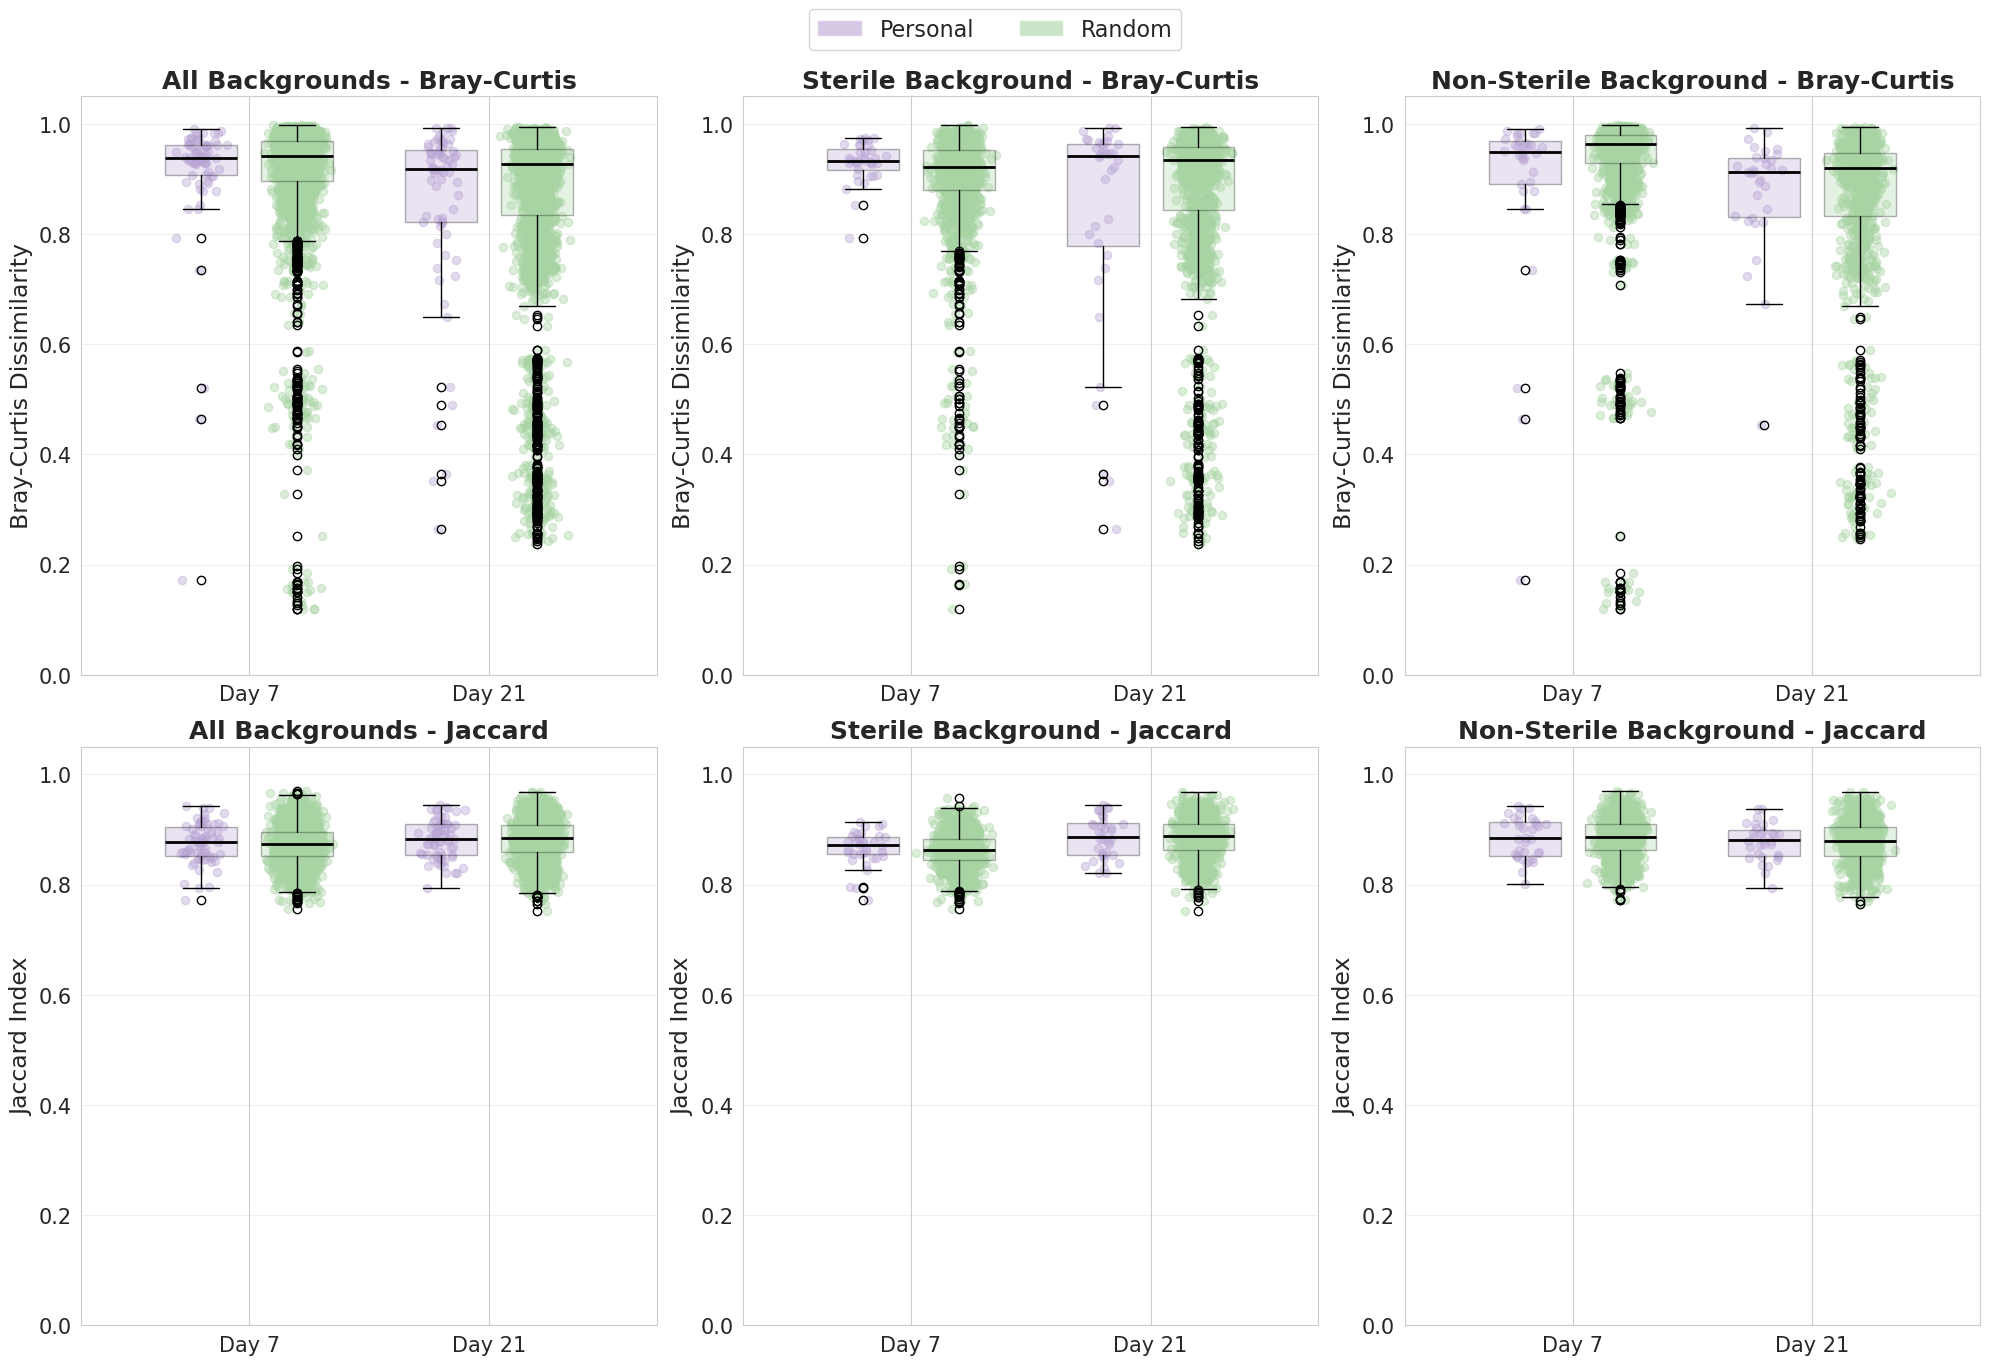


BRAY-CURTIS DISSIMILARITY:

STATISTICAL ANALYSIS: Personal vs Random Dissimilarities

ALL Background:
------------------------------------------------------------

Day 7:
  Personal: median=0.939, mean=0.910, n=70
  Random:   median=0.941, mean=0.915, n=3456
  Mann-Whitney U: U=119277.0, p=0.8418
  Result: No significant difference (ns)

Day 21:
  Personal: median=0.918, mean=0.854, n=68
  Random:   median=0.927, mean=0.865, n=2818
  Mann-Whitney U: U=92792.0, p=0.6565
  Result: No significant difference (ns)

STERILE Background:
------------------------------------------------------------

Day 7:
  Personal: median=0.933, mean=0.930, n=36
  Random:   median=0.922, mean=0.902, n=1850
  Mann-Whitney U: U=39805.0, p=0.0444
  Result: Significant difference (*)

Day 21:
  Personal: median=0.941, mean=0.835, n=36
  Random:   median=0.935, mean=0.870, n=1666
  Mann-Whitney U: U=30114.0, p=0.9657
  Result: No significant difference (ns)

NON-STERILE Background:
------------------------------

In [31]:
bc_dm_handdough = convert_skbio_to_df(bc_dm_handdough_skbio)


jaccard_dm_handdough = convert_skbio_to_df(jaccard_dm_handdough_skbio)

# Calculate dissimilarities for all backgrounds
print("Calculating Bray-Curtis dissimilarities...")
bc_all = calculate_dissimilarities(bc_dm_handdough, meta, background_type=None)
bc_sterile = calculate_dissimilarities(bc_dm_handdough, meta, background_type='sterile')
bc_nonsterile = calculate_dissimilarities(bc_dm_handdough, meta, background_type='non-sterile')
bc_results = pd.concat([bc_all, bc_sterile, bc_nonsterile], ignore_index=True)

print("Calculating Jaccard dissimilarities...")
jaccard_all = calculate_dissimilarities(jaccard_dm_handdough, meta, background_type=None)
jaccard_sterile = calculate_dissimilarities(jaccard_dm_handdough, meta, background_type='sterile')
jaccard_nonsterile = calculate_dissimilarities(jaccard_dm_handdough, meta, background_type='non-sterile')
jaccard_results = pd.concat([jaccard_all, jaccard_sterile, jaccard_nonsterile], ignore_index=True)

# Create plots
print("\nGenerating plots...")
plot_dissimilarity_comparison(bc_results, jaccard_results, 'Hand-Sourdough')

# Perform statistical tests
print("\n" + "="*80)
print("BRAY-CURTIS DISSIMILARITY:")
print("="*80)
perform_statistical_tests(bc_results)

print("\n\n" + "="*80)
print("JACCARD INDEX:")
print("="*80)
perform_statistical_tests(jaccard_results)

# Save results to CSV

print("Plots saved as 'hand_sourdough_dissimilarity_comparison.png'")

## Analysis of filtered only Sourdough metadata
<div style="background-color: skyblue; padding: 10px;">


### Initial plots

Plot the scatterplot and emperor visualization to gain an overview on the data

In [23]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-sourdough-only/scatterplot.qzv")

<visualization: Visualization uuid: a91ea949-2e02-4cb0-ac00-559bbd1d7791>

<div style="background-color: aliceblue; padding: 10px;">  
    
- bray curtis axis 1 explains 86 % of the difference and jaccard only 15 %  
- it seems like the background plays less and less a role (xField Bray-Curtis 1 yField day) and it seems to explain most of the difference in composition in the beginning)  
- if day21 aromas = null means, that they were no aromas, then lower pH is associated with more aromas

In [22]:
Visualization.load(f"{Data_diversity}/core-metrics-results-merged-sourdough-only/bray_curtis_emperor.qzv")

<visualization: Visualization uuid: c87f939c-98fc-49ab-a97e-069c48b26cdc>

In [21]:
Visualization.load(f"{Data_diversity}/core-metrics-results-merged-sourdough-only/jaccard_emperor.qzv")

<visualization: Visualization uuid: 3b9dca94-1d3b-406b-84ee-3f3bddc8d12f>

<div style="background-color: aliceblue; padding: 10px;">

- strong difference between background sterile & non-sterile
- some aromas on day 28 seem to appear either only on the sterile / non-sterile side (e.g. banana)

### Control that no effect trough different plates

Conducting control that no influence of different plates

Bray-curtis

In [3]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/bray_curtis_distance_matrix.qza \
    --m-metadata-file $Data_raw/merged_output.tsv\
    --m-metadata-column plate \
    --p-pairwise \
    --o-visualization $Data_diversity/kmerizer-results-merged-sourdough-only/bray-curtis-plate.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-sourdough-only/bray-curtis-plate.qzv


In [31]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-sourdough-only/bray-curtis-plate.qzv")

<visualization: Visualization uuid: 7ed2aea2-3ae0-4134-9c1f-f52650acc136>

Jaccard

In [5]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard_distance_matrix.qza \
    --m-metadata-file $Data_raw/merged_output.tsv\
    --m-metadata-column plate \
    --p-pairwise \
    --o-visualization $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard-plate.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-sourdough-only/jaccard-plate.qzv


In [6]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-sourdough-only/jaccard-plate.qzv")

<visualization: Visualization uuid: 2ccd8bd4-9d1a-43b4-9575-4eb7f44ad1e4>

<div style="background-color: aliceblue; padding: 10px;">
    
- no influence of plate on sourdough composition -> good

### Effect of Background on Sourdough

#### Change of both backgrounds over time

Testing if there's a change within one sample over time (pairing of sample day 7 & 21) and checking whether the changes are different in sterile vs non sterile  
Computing first with bray curtis metric

In [102]:
!qiime longitudinal pairwise-distances \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/bray_curtis_distance_matrix.qza \
    --m-metadata-file $Data_raw/merged_output.tsv \
    --p-state-column day \
    --p-group-column background \
    --p-state-1 7.0 \
    --p-state-2 21.0 \
    --p-individual-id-column person-id \
    --o-visualization $Data_diversity/kmerizer-results-merged-sourdough-only/bray-curtis-background-difference-over-time.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-sourdough-only/bray-curtis-background-difference-over-time.qzv


In [41]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-sourdough-only/bray-curtis-background-difference-over-time.qzv")

<visualization: Visualization uuid: 835d6a52-774d-43c7-acd1-0b9b21f9f883>

Plotting the distance as a scatterplot to see the distribution of change

Downloaded raw data as a tsv from above results and uploaded it into corresponding folder

In [34]:
effect_background_braycurtis = pd.read_csv(f'{Data_diversity}/kmerizer-results-merged-sourdough-only/pairs-effect-of-background-sourdough-bray-curtis.tsv', index_col=0, sep='\t')
effect_background_braycurtis.shape

(34, 3)

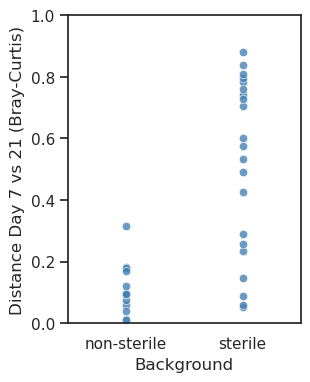

In [37]:
sns.set(rc={'figure.figsize':(3, 4)}, style='white')

with sns.plotting_context("notebook", font_scale=1):
    # seaborn's scatter plot
    ax = sns.scatterplot(
        effect_background_braycurtis, 
        x='Group', 
        y='Distance',
        alpha=0.8,
        color='steelblue')
    
    
    # matplotlib's customization
    ax.set_xlabel('Background')
    ax.set_ylabel('Distance Day 7 vs 21 (Bray-Curtis)')
    ax.set_ylim((0,1))
    ax.set_xlim(-0.5, 1.5) 

ax.tick_params(axis='y', which='major', left=True)

#ax.set_title('Change of Sourdoughs over time (Bray-Curtis)', fontsize=14)

plt.savefig(f'{Data_diversity}/kmerizer-results-merged-sourdough-only/Change_of_Sourdoughs_BrayCurtis.png', dpi=300, bbox_inches='tight')

Repeting computiations over time with jaccard metric

In [13]:
!qiime longitudinal pairwise-distances \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard_distance_matrix.qza \
    --m-metadata-file $Data_raw/merged_output.tsv \
    --p-state-column day \
    --p-group-column background \
    --p-state-1 7.0 \
    --p-state-2 21.0 \
    --p-individual-id-column person-id \
    --o-visualization $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard-background-difference-over-time.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-sourdough-only/jaccard-background-difference-over-time.qzv


In [14]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-sourdough-only/jaccard-background-difference-over-time.qzv")

<visualization: Visualization uuid: 54dff10c-0b8d-4e4c-abab-29902ad5822e>

Plotting the distance as a scatterplot to see the distribution of change

In [38]:
effect_background_jaccard = pd.read_csv(f'{Data_diversity}/kmerizer-results-merged-sourdough-only/pairs-effect-of-background-sourdough-jaccard.tsv', index_col=0, sep='\t')
effect_background_jaccard.shape

(34, 3)

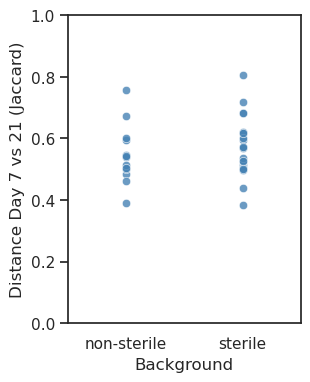

In [39]:
sns.set(rc={'figure.figsize':(3, 4)}, style='white')

with sns.plotting_context("notebook", font_scale=1):
    # seaborn's scatter plot
    ax = sns.scatterplot(
        effect_background_jaccard, 
        x='Group', 
        y='Distance',
        alpha=0.8,
        color='steelblue')
    
    
    # matplotlib's customization
    ax.set_xlabel('Background')
    ax.set_ylabel('Distance Day 7 vs 21 (Jaccard)')
    ax.set_ylim((0,1))
    ax.set_xlim(-0.5, 1.5) 

ax.tick_params(axis='y', which='major', left=True)

#ax.set_title('Change of Sourdoughs over time (Jaccard)', fontsize=14)

plt.savefig(f'{Data_diversity}/kmerizer-results-merged-sourdough-only/Change_of_Sourdoughs_Jaccard.png', dpi=300, bbox_inches='tight')

<div style="background-color: aliceblue; padding: 10px;">
    
There is a highly significant difference in change of the sourdough fungal abundance (significant bray-curtis (P-value: 0.000301)), but not in composition (non-significant jaccard) over time, depending on the background. 
There are samples also for the sterile background that also almost didn't change and some that did change a lot. The sterile background changed a lot more over time than the non-sterile

#### Testing day & background interaction

In [10]:
!qiime diversity adonis \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/bray_curtis_distance_matrix.qza \
    --m-metadata-file $Data_raw/merged_output_usable.tsv \
    --p-formula "day * background" \
    --o-visualization $Data_diversity/kmerizer-results-merged-sourdough-only/permanova_interaction_bray_curtis_day.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-sourdough-only/permanova_interaction_bray_curtis_day.qzv


In [3]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-sourdough-only/permanova_interaction_bray_curtis_day.qzv")

<visualization: Visualization uuid: 39c04e0f-b6c4-493d-a91c-2e003f059f24>

In [12]:
!qiime diversity adonis \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard_distance_matrix.qza \
    --m-metadata-file $Data_raw/merged_output_usable.tsv \
    --p-formula "day * background" \
    --o-visualization $Data_diversity/kmerizer-results-merged-sourdough-only/permanova_interaction_jaccard_day.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-sourdough-only/permanova_interaction_jaccard_day.qzv


In [43]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-sourdough-only/permanova_interaction_jaccard_day.qzv")

<visualization: Visualization uuid: 6e850d2e-e657-400e-af85-3e1a3c55a44e>

<div style="background-color: aliceblue; padding: 10px;">
    
There is a significant interaction of day & background

#### Comparison of different backgrounds at timepoint 7 & 21

Filtering distance matrix to only samples of day 7

In [25]:
df = pd.read_csv(f'{Data_diversity}/filtered-metadata/meta_sourdough.tsv', sep="\t")

columns_to_check = ["day"]

df_filtered = df[df["day"] == 7]

df_filtered.to_csv(f'{Data_diversity}/filtered-metadata/meta_day7.tsv', sep="\t", index=False)

In [28]:
!qiime diversity filter-distance-matrix \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/bray_curtis_distance_matrix.qza \
    --m-metadata-file $Data_diversity/filtered-metadata/meta_day7.tsv  \
    --o-filtered-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/bray_curtis_distance_matrix_day7.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/opt/conda/lib/python3.10/site-packages/qiime2/metadata/io.py:365: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  series = series.replace('', np.nan).infer_objects(copy=False)
Saved DistanceMatrix to: Data/diversity/kmerizer-results-merged-sourdough-only/bray_curtis_distance_matrix_day7.qza


In [29]:
!qiime diversity filter-distance-matrix \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard_distance_matrix.qza \
    --m-metadata-file $Data_diversity/filtered-metadata/meta_day7.tsv  \
    --o-filtered-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard_distance_matrix_day7.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/opt/conda/lib/python3.10/site-packages/qiime2/metadata/io.py:365: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  series = series.replace('', np.nan).infer_objects(copy=False)
Saved DistanceMatrix to: Data/diversity/kmerizer-results-merged-sourdough-only/jaccard_distance_matrix_day7.qza


Testing wether the distance of the two is significant on day 7

Bray-Curtis

In [30]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/bray_curtis_distance_matrix_day7.qza \
    --m-metadata-file $Data_raw/merged_output.tsv\
    --m-metadata-column background \
    --p-pairwise \
    --o-visualization $Data_diversity/kmerizer-results-merged-sourdough-only/bray-curtis-day7.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-sourdough-only/bray-curtis-day7.qzv


In [4]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-sourdough-only/bray-curtis-day7.qzv")

<visualization: Visualization uuid: c1551fec-2d87-4427-9d02-a22e58b8724f>

Jaccard

In [32]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard_distance_matrix_day7.qza \
    --m-metadata-file $Data_raw/merged_output.tsv\
    --m-metadata-column background \
    --p-pairwise \
    --o-visualization $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard-day7.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-sourdough-only/jaccard-day7.qzv


In [33]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-sourdough-only/jaccard-day7.qzv")

<visualization: Visualization uuid: f0fa8b77-8b30-433f-b715-6e3b5ec1f0bf>

Filtering distance matrix to only samples of day 21

In [27]:
df = pd.read_csv(f'{Data_diversity}/filtered-metadata/meta_sourdough.tsv', sep="\t")

columns_to_check = ["day"]

df_filtered = df[df["day"] == 21]

df_filtered.to_csv(f'{Data_diversity}/filtered-metadata/meta_day21.tsv', sep="\t", index=False)

In [34]:
!qiime diversity filter-distance-matrix \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/bray_curtis_distance_matrix.qza \
    --m-metadata-file $Data_diversity/filtered-metadata/meta_day21.tsv  \
    --o-filtered-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/bray_curtis_distance_matrix_day21.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/opt/conda/lib/python3.10/site-packages/qiime2/metadata/io.py:365: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  series = series.replace('', np.nan).infer_objects(copy=False)
Saved DistanceMatrix to: Data/diversity/kmerizer-results-merged-sourdough-only/bray_curtis_distance_matrix_day21.qza


In [35]:
!qiime diversity filter-distance-matrix \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard_distance_matrix.qza \
    --m-metadata-file $Data_diversity/filtered-metadata/meta_day21.tsv  \
    --o-filtered-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard_distance_matrix_day21.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/opt/conda/lib/python3.10/site-packages/qiime2/metadata/io.py:365: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  series = series.replace('', np.nan).infer_objects(copy=False)
Saved DistanceMatrix to: Data/diversity/kmerizer-results-merged-sourdough-only/jaccard_distance_matrix_day21.qza


Testing whether the distance of the two is significant on day 21

Bray-Curtis

In [36]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/bray_curtis_distance_matrix_day21.qza \
    --m-metadata-file $Data_raw/merged_output.tsv\
    --m-metadata-column background \
    --p-pairwise \
    --o-visualization $Data_diversity/kmerizer-results-merged-sourdough-only/bray-curtis-day21.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-sourdough-only/bray-curtis-day21.qzv


In [21]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-sourdough-only/bray-curtis-day21.qzv")

<visualization: Visualization uuid: c3852fde-c8ef-4176-99b8-a55d26ed962a>

Jaccard

In [37]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard_distance_matrix_day21.qza \
    --m-metadata-file $Data_raw/merged_output.tsv\
    --m-metadata-column background \
    --p-pairwise \
    --o-visualization $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard-day21.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-sourdough-only/jaccard-day21.qzv


In [23]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-sourdough-only/jaccard-day21.qzv")

<visualization: Visualization uuid: 1b300577-a341-4d59-adea-5d940e74949f>

<div style="background-color: aliceblue; padding: 10px;">
    
One can observe a decrease of the distance between the two backgrounds for day 21 compared to day 7

#### More detailed statistical testing of convergence of backgrounds over time

Filter metadata to only hand metadata

Load all necessary files

In [16]:
# Load your distance matrices
bc_matrix = Artifact.load(f'{Data_diversity}/kmerizer-results-merged-sourdough-only/bray_curtis_distance_matrix.qza')
bc_dm = bc_matrix.view(skbio.DistanceMatrix)

jaccard_matrix = Artifact.load(f'{Data_diversity}/kmerizer-results-merged-sourdough-only/jaccard_distance_matrix.qza')
jaccard_dm = jaccard_matrix.view(skbio.DistanceMatrix)

# Load metadata
metadata = pd.read_csv(f'{Data_diversity}/filtered-metadata/meta_sourdough.tsv', sep="\t", index_col=0)

Define funciton to calculate distance between groups, depandant on day

In [17]:
def get_between_group_distances(distance_matrix, metadata, day, group_column='background'):
    """
    Extract pairwise distances between different background groups at a specific timepoint
    """
    # Filter metadata for specific day
    day_samples = metadata[metadata['day'] == day].index
    
    # Get unique groups
    groups = metadata.loc[day_samples, group_column].unique()
    
    if len(groups) != 2:
        raise ValueError(f"Expected 2 groups, found {len(groups)}")
    
    # Get samples for each group
    group1_samples = metadata[(metadata['day'] == day) & 
                              (metadata[group_column] == groups[0])].index
    group2_samples = metadata[(metadata['day'] == day) & 
                              (metadata[group_column] == groups[1])].index
    
    # Extract between-group distances
    between_distances = []
    for s1 in group1_samples:
        for s2 in group2_samples:
            if s1 in distance_matrix.ids and s2 in distance_matrix.ids:
                between_distances.append(distance_matrix[s1, s2])
    
    return np.array(between_distances)

Get all distances

In [18]:
bc_day7 = get_between_group_distances(bc_dm, metadata, day=7)
bc_day14 = get_between_group_distances(bc_dm, metadata, day=14)
bc_day21 = get_between_group_distances(bc_dm, metadata, day=21)

jaccard_day7 = get_between_group_distances(jaccard_dm, metadata, day=7)
jaccard_day14 = get_between_group_distances(jaccard_dm, metadata, day=14)
jaccard_day21 = get_between_group_distances(jaccard_dm, metadata, day=21)

Print sample size to check whether everything went correct

In [19]:
print("=" * 70)
print("EXPLANATION OF SAMPLE SIZES")
print("=" * 70)
print(f"\nYou have {len(metadata)} total samples.")
print("\nSample distribution by day and background:")
for day in [7, 14, 21]:
    day_samples = metadata[metadata['day'] == day]
    print(f"\nDay {day}:")
    for bg in metadata['background'].unique():
        n = len(day_samples[day_samples['background'] == bg])
        print(f"  {bg}: {n} samples")
    
    # Calculate expected pairwise distances
    groups = day_samples['background'].unique()
    if len(groups) == 2:
        n1 = len(day_samples[day_samples['background'] == groups[0]])
        n2 = len(day_samples[day_samples['background'] == groups[1]])
        n_pairs = n1 * n2
        print(f"  → Between-group pairwise distances: {n1} × {n2} = {n_pairs}")

EXPLANATION OF SAMPLE SIZES

You have 125 total samples.

Sample distribution by day and background:

Day 7:
  non-sterile: 20 samples
  sterile: 25 samples
  → Between-group pairwise distances: 25 × 20 = 500

Day 14:
  non-sterile: 19 samples
  sterile: 22 samples
  → Between-group pairwise distances: 19 × 22 = 418

Day 21:
  non-sterile: 16 samples
  sterile: 23 samples
  → Between-group pairwise distances: 16 × 23 = 368


Create data frame for plotting

In [20]:
data_bc = pd.DataFrame({
    'Distance': np.concatenate([bc_day7, bc_day14, bc_day21]),
    'Day': ['Day 7'] * len(bc_day7) + ['Day 14'] * len(bc_day14) + ['Day 21'] * len(bc_day21),
    'Metric': 'Bray-Curtis'
})

data_jaccard = pd.DataFrame({
    'Distance': np.concatenate([jaccard_day7, jaccard_day14, jaccard_day21]),
    'Day': ['Day 7'] * len(jaccard_day7) + ['Day 14'] * len(jaccard_day14) + ['Day 21'] * len(jaccard_day21),
    'Metric': 'Jaccard'
})

# Combine data
data_combined = pd.concat([data_bc, data_jaccard], ignore_index=True)

Plot the differences over time to see wether they are converging or not

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert

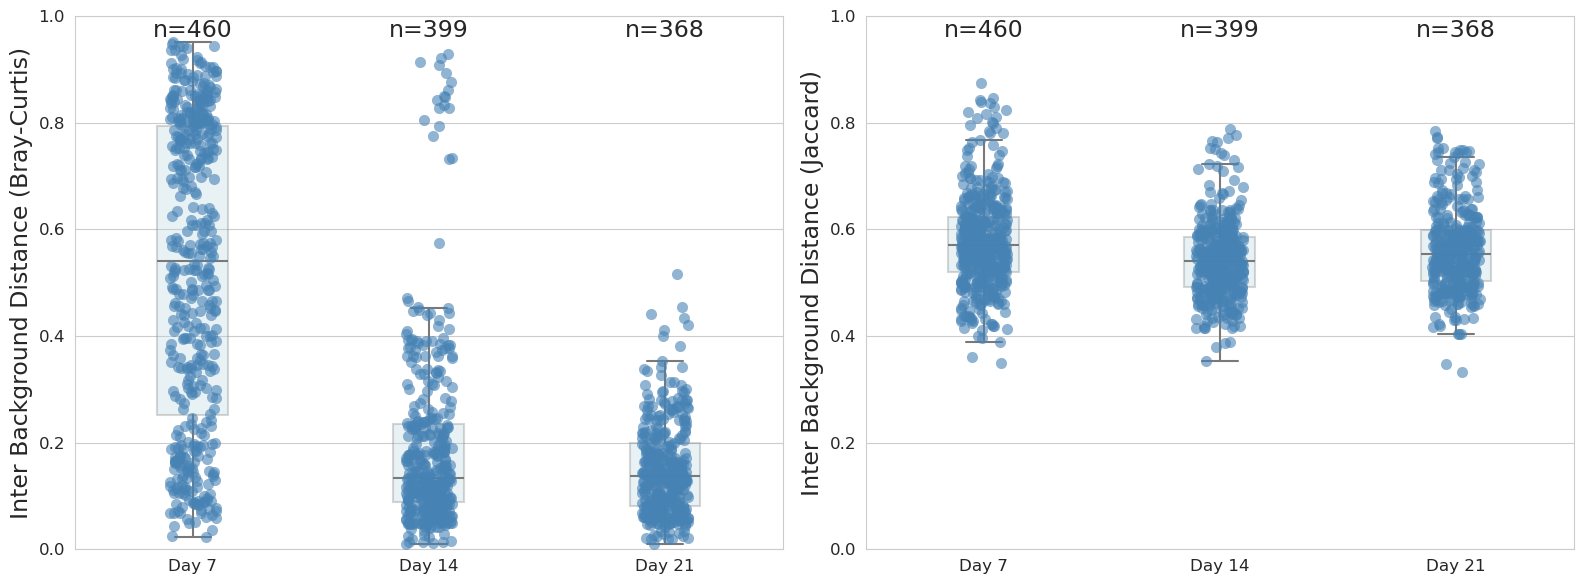

In [32]:
# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 12

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Bray-Curtis
ax1 = axes[0]
sns.stripplot(data=data_bc, x='Day', y='Distance', 
              color='steelblue', alpha=0.6, size=8, ax=ax1,
              order=['Day 7', 'Day 14', 'Day 21'])
sns.boxplot(data=data_bc, x='Day', y='Distance', 
            color='lightblue', width=0.3, ax=ax1,
            boxprops=dict(alpha=0.3), showfliers=False,
            order=['Day 7', 'Day 14', 'Day 21'])

ax1.set_ylabel('Inter Background Distance (Bray-Curtis)', fontsize=17)
ax1.set_xlabel('') #I've found no other way to get rid of the redundant Day
ax1.set_ylim(0, 1.0)

# Add sample sizes
ax1.text(0, 0.96, f'n={len(bc_day7)}', ha='center', fontsize=17)
ax1.text(1, 0.96, f'n={len(bc_day14)}', ha='center', fontsize=17)
ax1.text(2, 0.96, f'n={len(bc_day21)}', ha='center', fontsize=17)

# Plot 2: Jaccard
ax2 = axes[1]
sns.stripplot(data=data_jaccard, x='Day', y='Distance', 
              color='steelblue', alpha=0.6, size=8, ax=ax2,
              order=['Day 7', 'Day 14', 'Day 21'])
sns.boxplot(data=data_jaccard, x='Day', y='Distance', 
            color='lightblue', width=0.3, ax=ax2,
            boxprops=dict(alpha=0.3), showfliers=False,
            order=['Day 7', 'Day 14', 'Day 21'])

ax2.set_ylabel('Inter Background Distance (Jaccard)', fontsize=17)
    
ax2.set_ylim(0, 1.0)

# Add sample sizes
ax2.text(0, 0.96, f'n={len(jaccard_day7)}', ha='center', fontsize=17)
ax2.text(1, 0.96, f'n={len(jaccard_day14)}', ha='center', fontsize=17)
ax2.text(2, 0.96, f'n={len(jaccard_day21)}', ha='center', fontsize=17)
ax2.set_xlabel('') #I've found no other way to get rid of the redundant Day
plt.tight_layout()
plt.savefig(f'{Data_diversity}/kmerizer-results-merged-sourdough-only/between_group_distance_comparison-over-time.png', 
            dpi=300, bbox_inches='tight')
plt.show()

Print summary statistic to gain overview of values

In [54]:
print("=" * 70)
print("BETWEEN-BACKGROUND DISTANCE SUMMARY")
print("=" * 70)
print("\nBray-Curtis Distances:")
print(f"  Day 7:  Mean = {mean_day7_bc:.4f}, SD = {bc_day7.std():.4f}, n = {len(bc_day7)}")
print(f"  Day 14: Mean = {mean_day14_bc:.4f}, SD = {bc_day14.std():.4f}, n = {len(bc_day14)}")
print(f"  Day 21: Mean = {mean_day21_bc:.4f}, SD = {bc_day21.std():.4f}, n = {len(bc_day21)}")
print(f"  Change (Day 7→21): {mean_day7_bc - mean_day21_bc:.4f} ({((mean_day7_bc - mean_day21_bc)/mean_day7_bc*100):.1f}% decrease)")

print("\nJaccard Distances:")
print(f"  Day 7:  Mean = {mean_day7_jac:.4f}, SD = {jaccard_day7.std():.4f}, n = {len(jaccard_day7)}")
print(f"  Day 14: Mean = {mean_day14_jac:.4f}, SD = {jaccard_day14.std():.4f}, n = {len(jaccard_day14)}")
print(f"  Day 21: Mean = {mean_day21_jac:.4f}, SD = {jaccard_day21.std():.4f}, n = {len(jaccard_day21)}")
print(f"  Change (Day 7→21): {mean_day7_jac - mean_day21_jac:.4f} ({((mean_day7_jac - mean_day21_jac)/mean_day7_jac*100):.1f}% decrease)")

BETWEEN-BACKGROUND DISTANCE SUMMARY

Bray-Curtis Distances:
  Day 7:  Mean = 0.5225, SD = 0.2812, n = 460
  Day 14: Mean = 0.1960, SD = 0.1776, n = 399
  Day 21: Mean = 0.1506, SD = 0.0861, n = 368
  Change (Day 7→21): 0.3719 (71.2% decrease)

Jaccard Distances:
  Day 7:  Mean = 0.5774, SD = 0.0875, n = 460
  Day 14: Mean = 0.5425, SD = 0.0716, n = 399
  Day 21: Mean = 0.5598, SD = 0.0775, n = 368
  Change (Day 7→21): 0.0177 (3.1% decrease)


Doing statistical testing of day 7 compared to day 21
With Mann-Whitney U for independant testing which doesn't assume normal distribution
and with cohen's d to look at effect size

In [64]:
# Bray-Curtis comprehensive testing
print("\n" + "="*70)
print("BRAY-CURTIS DISTANCES")
print("="*70)

# Mann-Whitney U
stat_bc_14, p_bc_14 = stats.mannwhitneyu(bc_day7, bc_day14, alternative='greater')
print(f"  Day 7 vs Day 14: p = {p_bc_14:.6f}   U-statistic: {stat_bc_14:.2f}")
stat_bc_1421, p_bc_1421 = stats.mannwhitneyu(bc_day14, bc_day21, alternative='greater')
print(f"  Day 14 vs Day 21: p = {p_bc_1421:.6f} U-statistic: {stat_bc_1421:.2f}")
stat_bc, p_bc = stats.mannwhitneyu(bc_day7, bc_day21, alternative='greater')
print(f"  Day 7 vs Day 21: p = {p_bc:.6f} U-statistic: {stat_bc:.2f}")
print(f"   Result: {'✓ SIGNIFICANT overall convergence (p < 0.05)' if p_bc < 0.05 else '✗ No significant convergence'}")

# Effect size
pooled_std_bc = np.sqrt((bc_day7.std()**2 + bc_day21.std()**2) / 2)
cohens_d_bc = (bc_day7.mean() - bc_day21.mean()) / pooled_std_bc
print(f" Effect Size (Cohen's d)")
print(f"   Cohen's d: {cohens_d_bc:.4f}")
if abs(cohens_d_bc) < 0.2:
    interpretation = "negligible"
elif abs(cohens_d_bc) < 0.5:
    interpretation = "small"
elif abs(cohens_d_bc) < 0.8:
    interpretation = "medium"
else:
    interpretation = "large"
print(f"   Interpretation: {interpretation} effect")

# Jaccard comprehensive testing
print("\n" + "="*70)
print("JACCARD DISTANCES")
print("="*70)

# Mann-Whitney U
stat_jac_14, p_jac_14 = stats.mannwhitneyu(jaccard_day7, jaccard_day14, alternative='greater')
print(f"  Day 7 vs Day 14: p = {p_jac_14:.6f} U-statistic: {stat_jac_14:.2f}")
stat_jac_1421, p_jac_1421 = stats.mannwhitneyu(jaccard_day14, jaccard_day21, alternative='greater')
print(f"  Day 14 vs Day 21: p = {p_jac_1421:.6f} U-statistic: {stat_jac_1421:.2f}")
stat_jac, p_jac = stats.mannwhitneyu(jaccard_day7, jaccard_day21, alternative='greater')
print(f"  Day 7 vs Day 21: p = {p_jac:.6f} U-statistic: {stat_jac:.2f}")
stat_jac, p_jac = stats.mannwhitneyu(jaccard_day7, jaccard_day21, alternative='greater')

print(f"   Result: {'✓ SIGNIFICANT overall convergence (p < 0.05)' if p_jac < 0.05 else '✗ No significant convergence'}")

# Effect size
pooled_std_jac = np.sqrt((jaccard_day7.std()**2 + jaccard_day21.std()**2) / 2)
cohens_d_jac = (jaccard_day7.mean() - jaccard_day21.mean()) / pooled_std_jac
print(f" Effect Size (Cohen's d)")
print(f"   Cohen's d: {cohens_d_jac:.4f}")
if abs(cohens_d_jac) < 0.2:
    interpretation = "negligible"
elif abs(cohens_d_jac) < 0.5:
    interpretation = "small"
elif abs(cohens_d_jac) < 0.8:
    interpretation = "medium"
else:
    interpretation = "large"
print(f"   Interpretation: {interpretation} effect")


print("\n" + "=" * 70)


BRAY-CURTIS DISTANCES
  Day 7 vs Day 14: p = 0.000000   U-statistic: 150961.00
  Day 14 vs Day 21: p = 0.049025 U-statistic: 78488.00
  Day 7 vs Day 21: p = 0.000000 U-statistic: 146673.00
   Result: ✓ SIGNIFICANT overall convergence (p < 0.05)
 Effect Size (Cohen's d)
   Cohen's d: 1.7887
   Interpretation: large effect

JACCARD DISTANCES
  Day 7 vs Day 14: p = 0.000000 U-statistic: 114817.00
  Day 14 vs Day 21: p = 0.998704 U-statistic: 64182.00
  Day 7 vs Day 21: p = 0.000648 U-statistic: 95641.50
   Result: ✓ SIGNIFICANT overall convergence (p < 0.05)
 Effect Size (Cohen's d)
   Cohen's d: 0.2137
   Interpretation: small effect



### Effect of storage temperature & place

Investigating effect of storage temperature & location & day (because it was shown that time has an effect, so also need to consider that) on fungal composition; with adonis to see whether there is an interaction effect

Bray-curtis

In [3]:
! qiime diversity adonis \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/bray_curtis_distance_matrix_survey.qza \
    --m-metadata-file $Data_diversity/filtered-metadata/meta_survey.tsv  \
    --p-formula "day*sd_stor_loc*sd_stor_temp" \
    --o-visualization $Data_diversity/kmerizer-results-merged-sourdough-only/bray_curtis_storageday.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-sourdough-only/bray_curtis_storageday.qzv


In [6]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-sourdough-only/bray_curtis_storageday.qzv")

<visualization: Visualization uuid: 9b60c23d-9165-4188-b6a7-3ad126b67a01>

Jaccard

In [7]:
! qiime diversity adonis \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard_distance_matrix_survey.qza \
    --m-metadata-file $Data_diversity/filtered-metadata/meta_survey.tsv  \
    --p-formula "day*sd_stor_loc*sd_stor_temp" \
    --o-visualization $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard_storageday.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-sourdough-only/jaccard_storageday.qzv


In [8]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-sourdough-only/jaccard_storageday.qzv")

<visualization: Visualization uuid: 7b87850e-3214-4d99-9e36-5b2529c2259b>

<div style="background-color: aliceblue; padding: 10px;">
    
No influence of storage location or temperature on sd on abundance & compositon

### Effect of latitude & longitude

Investigating the effect of the location (latitude & longitude) & day (because it was shown that time has an effect, so also need to consider that) with adonis, to also see whether there is an interaction effect between latitude & longitude

Bray-curtis

In [9]:
! qiime diversity adonis \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/bray_curtis_distance_matrix_survey.qza \
    --m-metadata-file $Data_diversity/filtered-metadata/meta_survey.tsv  \
    --p-formula "day*latitude*longitude" \
    --o-visualization $Data_diversity/kmerizer-results-merged-sourdough-only/bray_curtis_locationday.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-sourdough-only/bray_curtis_locationday.qzv


In [10]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-sourdough-only/bray_curtis_locationday.qzv")

<visualization: Visualization uuid: bff7fc9c-a061-4f79-95a6-743af8e29224>

Jaccard

In [11]:
! qiime diversity adonis \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard_distance_matrix_survey.qza \
    --m-metadata-file $Data_diversity/filtered-metadata/meta_survey.tsv  \
    --p-formula "day*latitude*longitude" \
    --o-visualization $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard_locationday.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-sourdough-only/jaccard_locationday.qzv


In [12]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-sourdough-only/jaccard_locationday.qzv")

<visualization: Visualization uuid: 4262f423-2ab9-40a1-9f67-905dc44dce46>

<div style="background-color: aliceblue; padding: 10px;">

- geographical location doesn't explain difference in abundance & composition of the sourdough's  
- but as they all go to the same highschool, makes sense

### Effect of plants

Fill in NaN's with no (I manually checked and for all the missing values in plants_in_sd_room the persons answered already with no to plants, so there is also no posiblility for plants in the room with the sourdough

In [54]:
df = pd.read_csv(f'{Data_diversity}/filtered-metadata/meta_survey.tsv', sep="\t")

columns_to_check = ["plants_in_sd_room"]

df[columns_to_check] = df[columns_to_check].fillna("no")
df.to_csv(f'{Data_diversity}/filtered-metadata/meta_plants.tsv', sep="\t", index=False)

Investigating effect of plants & day (because it was shown that time has an effect, so also need to consider that) on fungal composition; with adonis to see whether there is an interaction effect

Bray-curtis

In [13]:
! qiime diversity adonis \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/bray_curtis_distance_matrix_survey.qza \
    --m-metadata-file $Data_diversity/filtered-metadata/meta_plants.tsv  \
    --p-formula "day*plants*plants_in_sd_room" \
    --o-visualization $Data_diversity/kmerizer-results-merged-sourdough-only/bray_curtis_plantsday.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-sourdough-only/bray_curtis_plantsday.qzv


In [14]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-sourdough-only/bray_curtis_plantsday.qzv")

<visualization: Visualization uuid: c9dc255d-9eb8-49da-8778-ee6a26e57c6d>

Jaccard

In [15]:
! qiime diversity adonis \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard_distance_matrix_survey.qza \
    --m-metadata-file $Data_diversity/filtered-metadata/meta_plants.tsv  \
    --p-formula "day*plants*plants_in_sd_room" \
    --o-visualization $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard_plantsday.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-sourdough-only/jaccard_plantsday.qzv


In [16]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-sourdough-only/jaccard_plantsday.qzv")

<visualization: Visualization uuid: d3f5d30e-5357-42dd-aa8e-731386706c99>

<div style="background-color: aliceblue; padding: 10px;">

Plants do not have an influence on fungal composition or abundance

### Effect of pets

Fill in NaN's for 0 because adonis can't work with NaN's and we already have just the metadata for people who filled out the survey

In [55]:
df = pd.read_csv(f'{Data_diversity}/filtered-metadata/meta_survey.tsv', sep="\t")

columns_to_check = ["guinea_pig", "cat", "dog", "turtle", "fish"]

df[columns_to_check] = df[columns_to_check].fillna(0.0)
df.to_csv(f'{Data_diversity}/filtered-metadata/meta_pets.tsv', sep="\t", index=False)

Investigating effect of pets & day (because it was shown that time has an effect, so also need to consider that) on fungal composition; with adonis to see whether there is an interaction effect   
Bray curtis (no need to filter distance matrix, as same as before (survey))

In [17]:
! qiime diversity adonis \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/bray_curtis_distance_matrix_survey.qza \
    --m-metadata-file $Data_diversity/filtered-metadata/meta_pets.tsv  \
    --p-formula "day*guinea_pig*cat*dog*turtle*fish" \
    --o-visualization $Data_diversity/kmerizer-results-merged-sourdough-only/bray_curtis_petsday.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-sourdough-only/bray_curtis_petsday.qzv


In [18]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-sourdough-only/bray_curtis_petsday.qzv")

<visualization: Visualization uuid: 75a788d2-8d93-44f1-aded-8a9a8074c96b>

Jaccard (no need to filter distance matrix, as same as before (survey))

In [19]:
! qiime diversity adonis \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard_distance_matrix_survey.qza \
    --m-metadata-file $Data_diversity/filtered-metadata/meta_pets.tsv  \
    --p-formula "day*guinea_pig*cat*dog*turtle*fish" \
    --o-visualization $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard_petsday.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-sourdough-only/jaccard_petsday.qzv


In [20]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-sourdough-only/jaccard_petsday.qzv")

<visualization: Visualization uuid: 16991080-9095-4b35-aa23-4be0655d09d9>

<div style="background-color: aliceblue; padding: 10px;">

Pets do not have an influence on fungal composition or abundance

## Analysis of filtered only Hand metadata
<div style="background-color: skyblue; padding: 10px;">


### Initial plots

In [38]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-hand-only/scatterplot.qzv")

<visualization: Visualization uuid: 9af8a0ba-0668-4f99-8939-f3668ed88c58>

In [33]:
Visualization.load(f"{Data_diversity}/core-metrics-results-merged-hand-only/bray_curtis_emperor.qzv")

<visualization: Visualization uuid: 1d2a7760-bdc0-4178-a1a9-56cda4bfd420>

In [32]:
Visualization.load(f"{Data_diversity}/core-metrics-results-merged-hand-only/jaccard_emperor.qzv")

<visualization: Visualization uuid: df534811-462e-4edb-a7e4-87abcbdb57a8>

<div style="background-color: aliceblue; padding: 10px;">  
    
- bray curtis explains 14 % of the difference and jaccard 6 %  
- generally smaller distribution than sourdough samples
- no difference of sourdoughbackground on hand fungal composition visible  
- slight clustering based on aromas of day 21 (e.g. animal stable, beer, berries, chickpea)  
- bread & buttermilk aromas on day 21 are the same, on the other days similar but not the same
- there doesn't seem to be a correlation between yeast / sourdough bake experience and hand fungal composition

### Control that no effect trough different plates

Conducting control that no influence of different plates

Bray-curtis

In [1]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-hand-only/bray_curtis_distance_matrix.qza \
    --m-metadata-file $Data_raw/merged_output.tsv\
    --m-metadata-column plate \
    --p-pairwise \
    --o-visualization $Data_diversity/kmerizer-results-merged-hand-only/bray-curtis-plate.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
^C

Aborted!


In [2]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-hand-only/bray-curtis-plate.qzv")

NameError: name 'Visualization' is not defined

Jaccard

In [34]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-hand-only/jaccard_distance_matrix.qza \
    --m-metadata-file $Data_raw/merged_output.tsv\
    --m-metadata-column plate \
    --p-pairwise \
    --o-visualization $Data_diversity/kmerizer-results-merged-hand-only/jaccard-plate.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-hand-only/jaccard-plate.qzv


In [5]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-hand-only/jaccard-plate.qzv")

<visualization: Visualization uuid: 19d4fb9d-d1c8-4603-9630-21256edd313f>

<div style="background-color: aliceblue; padding: 10px;">  
    
- there seems to be a difference between the plates  
- it can also be seen in the jaccard emperor plot  
- for the bray curtis it can also be that due to large sample size, even small differences become statistically relevant

### Comparison of hands

Comparison of left & right hand

Bray-Curtis

In [33]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-hand-only/bray_curtis_distance_matrix.qza \
    --m-metadata-file $Data_raw/20250913_metadata_ITS.tsv \
    --m-metadata-column hand \
    --p-pairwise \
    --o-visualization $Data_diversity/kmerizer-results-merged-hand-only/bray_curtis-hand-significance.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-hand-only/bray_curtis-hand-significance.qzv


In [34]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-hand-only/bray_curtis-hand-significance.qzv")

<visualization: Visualization uuid: 85970df9-c172-4664-8690-ed55b9015c0f>

Jaccard

In [35]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-hand-only/jaccard_distance_matrix.qza \
    --m-metadata-file $Data_raw/20250913_metadata_ITS.tsv \
    --m-metadata-column hand \
    --p-pairwise \
    --o-visualization $Data_diversity/kmerizer-results-merged-hand-only/jaccard-hand-significance.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-hand-only/jaccard-hand-significance.qzv


In [36]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-hand-only/jaccard-hand-significance.qzv")

<visualization: Visualization uuid: f2e4878f-fdbe-492f-ab0c-42afffc86774>

<div style="background-color: aliceblue; padding: 10px;">

- there is no difference in abundance or composition between right & left hand
- Bray-Curtis: p & q value: 0.876, pseudo F-value: 0.715672
- Jaccard: p & q value: 0.58 and pseude F-value: 0.964955